In [57]:
from pathlib import Path
import pandas as pd

train_set = pd.read_csv(Path("data/train.csv"))
test_set = pd.read_csv(Path("data/test.csv"))

In [58]:
train_set.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


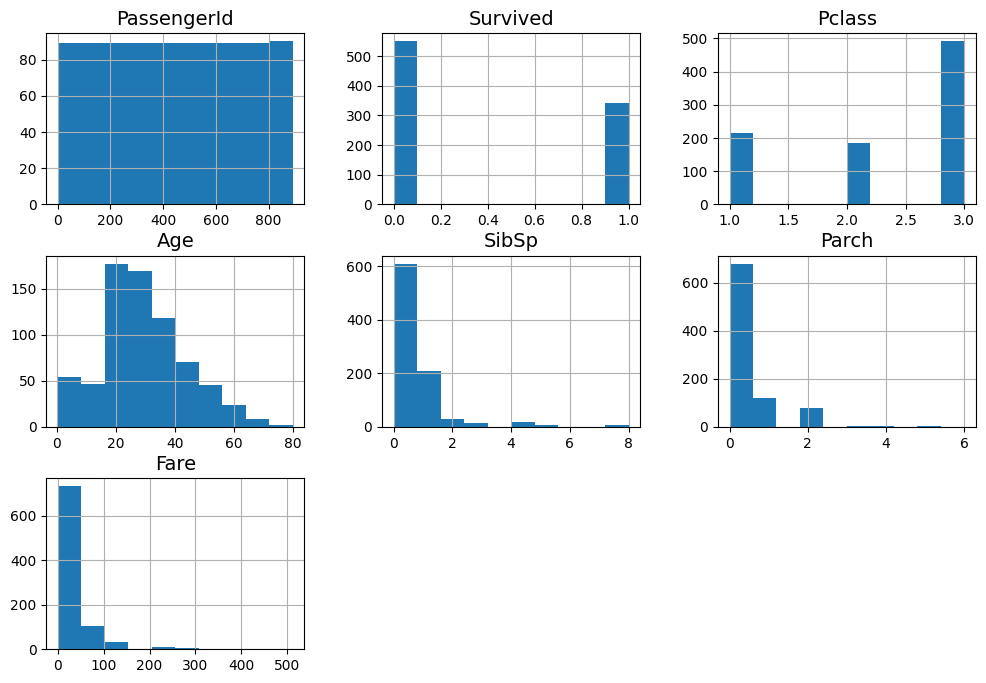

In [59]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_set.hist(figsize=(12, 8))
plt.show()

In [60]:
working_set = train_set.copy()
working_set_labels = working_set["Survived"].copy()
working_set.drop(columns=["Survived"], inplace=True)

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FunctionTransformer, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

embarked_pipeline = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(drop="first", sparse_output=False))

impute_scale_pipeline = make_pipeline(
        SimpleImputer(strategy="median"))

family_fare_pipeline = make_pipeline(
    FunctionTransformer(
        lambda X: pd.DataFrame({
            "FamilySize": X.iloc[:, 0] + X.iloc[:, 1] + 1,
            "FarePerPerson": X.iloc[:, 2] / (X.iloc[:, 0] + X.iloc[:, 1] + 1)
        }),
        feature_names_out=lambda X1, X2: ["FamilySize", "FarePerPerson"]
    )
)

def cabin_transform(X):
    return pd.DataFrame(X).map(lambda x: 'F' if x[0] == 'T' else x[0])

cabin_pipeline = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="G"),
        FunctionTransformer(
            cabin_transform,
            feature_names_out=lambda X1, X2: ["Cabin"]),
        OrdinalEncoder(categories=[list("ABCDEFG")], dtype=int))

preprocessor = ColumnTransformer(
    transformers=[
        ("impute_scale", impute_scale_pipeline, ["Age"]),
        ("family_fare", family_fare_pipeline, ["SibSp", "Parch", "Fare"]),
        ("impute_onehot", embarked_pipeline, ["Embarked"]),
        ("cabin", cabin_pipeline, ["Cabin"]),
        ("sex_encoder", OrdinalEncoder(categories=[["male", "female"]]), ["Sex"]),
        ("pass", "passthrough", ["Pclass"]),
    ]
)

working_set_pp = pd.DataFrame(preprocessor.fit_transform(working_set), columns=preprocessor.get_feature_names_out())
working_set_pp.head(10)

,impute_scale__Age,family_fare__FamilySize,family_fare__FarePerPerson,impute_onehot__Embarked_Q,impute_onehot__Embarked_S,cabin__Cabin,sex_encoder__Sex,pass__Pclass
0,22.0,2.0,3.62500,0.0,1.0,6.0,0.0,3.0
1,38.0,2.0,35.64165,0.0,0.0,2.0,1.0,1.0
2,26.0,1.0,7.92500,0.0,1.0,6.0,1.0,3.0
3,35.0,2.0,26.55000,0.0,1.0,2.0,1.0,1.0
4,35.0,1.0,8.05000,0.0,1.0,6.0,0.0,3.0
5,28.0,1.0,8.45830,1.0,0.0,6.0,0.0,3.0
6,54.0,1.0,51.86250,0.0,1.0,4.0,0.0,1.0
7,2.0,5.0,4.21500,0.0,1.0,6.0,0.0,3.0
8,27.0,3.0,3.71110,0.0,1.0,6.0,1.0,3.0
9,14.0,2.0,15.03540,0.0,0.0,6.0,1.0,2.0


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(working_set_pp, working_set_labels, test_size=0.2, random_state=42)

# Train the linear regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaluate the model
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8156424581005587


/home/dragos/workspaces/python/Kaggle-Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.8044692737430168


In [81]:
rf_clf.fit(working_set_pp, working_set_labels)

RandomForestClassifier(random_state=42)

In [82]:
test_set_pp = pd.DataFrame(preprocessor.transform(test_set), columns=preprocessor.get_feature_names_out())

test_set_predict = rf_clf.predict(test_set_pp)

submission = pd.DataFrame({
    "PassengerId": test_set["PassengerId"],
    "Survived": test_set_predict
})

submission.to_csv("data/submission.csv", index=False)
